In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import casadi.tools as ct

In [4]:
def problem_data():
    """ Problem data, numeric constants,...
    """

    data = {}
    data['a'] = 0.5616
    data['b'] = 0.3126
    data['c'] = 48.43
    data['d'] = 0.507
    data['e'] = 55.0
    data['f'] = 0.1538
    data['g'] = 90.0
    data['h'] = 0.16

    data['M'] = 20.0
    data['C'] = 4.0
    data['UA2'] = 6.84
    data['Cp'] = 0.07
    data['lam'] = 38.5
    data['lams'] = 36.6
    data['F1'] = 10.0
    data['X1'] = 5.0
    data['F3'] = 50.0
    data['T1'] = 40.0
    data['T200'] = 25.0

    return data

def intermediate_vars(x, u, data):

    """ Intermediate model variables
    """

    data['T2'] = data['a']*x['P2'] + data['b']*x['X2'] + data['c']
    data['T3'] = data['d']*x['P2'] + data['e']
    data['T100'] = data['f']*u['P100'] + data['g'] # added noise
    data['UA1'] = data['h']*(data['F1']+data['F3'])
    data['Q100'] = data['UA1']*(data['T100'] - data['T2'])
    data['F100'] = data['Q100']/data['lams']
    data['Q200'] = data['UA2']*(data['T3']-data['T200'])/(1.0 + data['UA2']/(2.0*data['Cp']*u['F200']))
    data['F5'] = data['Q200']/data['lam']
    data['F4'] = (data['Q100']-data['F1']*data['Cp']*(data['T2']-data['T1']))/data['lam']
    data['F2'] = (data['F1'] - data['F4'])
    return data

def intermediate_vars_noisy(x, u, data):

    """ Intermediate model variables
    """
    # Add noise to X1, F2, T1, T200
    data['X1'] += u['X1_noise']
    data['T1'] += u['T1_noise']
    data['T200'] += u['T200_noise']

    data['T2'] = data['a']*x['P2'] + data['b']*x['X2'] + data['c']
    data['T3'] = data['d']*x['P2'] + data['e']
    data['T100'] = data['f']*u['P100'] + data['g'] # added noise
    data['UA1'] = data['h']*(data['F1']+data['F3'])
    data['Q100'] = data['UA1']*(data['T100'] - data['T2'])
    data['F100'] = data['Q100']/data['lams']
    data['Q200'] = data['UA2']*(data['T3']-data['T200'])/(1.0 + data['UA2']/(2.0*data['Cp']*u['F200']))
    data['F5'] = data['Q200']/data['lam']
    data['F4'] = (data['Q100']-data['F1']*data['Cp']*(data['T2']-data['T1']))/data['lam']
    data['F2'] = (data['F1'] - data['F4'])
    data['F2'] += u['F2_noise']
    return data

In [5]:
def dynamics(x, u, data):

    """ System dynamics function (discrete time)
    """

    # state derivative expression
    xdot = ca.vertcat(
        (data['F1']*data['X1'] - data['F2']*x['X2'])/data['M'],
        (data['F4'] - data['F5'])/data['C']
        )

    # create ode for integrator
    ode = {'x':x, 'p':u,'ode': xdot}

    return [ca.integrator('F','collocation',ode,{'tf':1}), ode]

def vars():

    """ System states and controls
    """

    x = ct.struct_symMX(['X2','P2'])
    u = ct.struct_symMX(['P100','F200'])

    return x, u

def vars_noisy():

    """ System states and controls
    """

    x = ct.struct_symMX(['X2','P2'])
    u = ct.struct_symMX(['P100','F200','X1_noise','F2_noise','T1_noise','T200_noise'])

    return x, u

def objective(x, u, data):

    """ Economic objective function
    """
    
    # cost definition
    obj = 10.09*(data['F2']+data['F3']) + 600.0*data['F100'] + 0.6*u['F200']

    return ca.Function('economic_cost',[x,u],[obj])

def constraints(x, u, data):
    
    """ Path inequality constraints function (convention h(x,u) >= 0)
    """

    constr = ca.vertcat(
        x['X2'] - 25.0,
        x['P2'] - 40.0,
        100.0 - x['X2'],
        80.0 - x['P2'],
        400.0 - u['P100'],
        400.0 - u['F200'],
    )

    return ca.Function('h', [x,u], [constr])

In [6]:
# set-up system
x, u = vars()
data = intermediate_vars(x, u, problem_data())
f = dynamics(x, u, data)[0]
l = objective(x, u, data)
h = constraints(x, u, data)
# set-up noisy system
x, u_noisy = vars_noisy()
data_noisy = intermediate_vars_noisy(x, u_noisy, problem_data())
f_noisy = dynamics(x, u_noisy, data_noisy)[0]
l_noisy = objective(x, u_noisy, data_noisy)
h_noisy = constraints(x, u_noisy, data_noisy)

CasADi - 2023-10-03 06:00:44 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [7]:
res = f(x0=x, p=u)
x_next = res['xf'] # Access x_next as the DAE symbolic solution
# Define function F to simplify mapping between symbolic (x,u) --> (x_next)
F = ca.Function('F',[x,u],[x_next],['x','u'],['x_next'])

res_noisy = f_noisy(x0=x, p=u_noisy)
x_next_noisy = res_noisy['xf']
F_noisy = ca.Function('F_noisy',[x,u_noisy],[x_next_noisy],['x','u_noisy'],['x_next'])

In [16]:
T = 300
Ts = 1
N = 10
x_s = [25.0, 49.743]
u_s = [191.713, 215.888]
# Test steady state validity
print(F(x_s, u_s))

[25, 49.743]


In [39]:
t = np.arange(0,T,Ts)
u = 10*np.random.randn(*t.shape, 2)

In [45]:
cmap = plt.get_cmap('plasma')

(0.086222, 0.026125, 0.542658, 1.0)

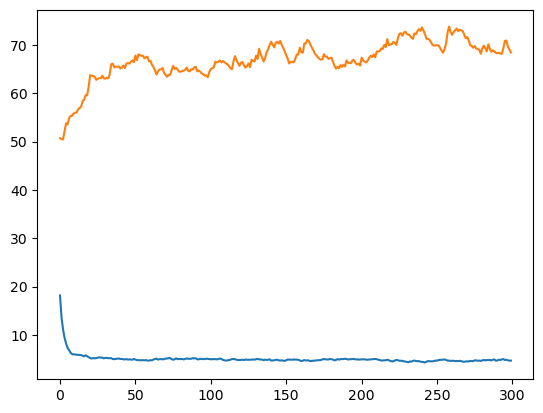

In [41]:
X_log = np.empty((2,0))
U_log = np.empty((2,0))

x_0 = np.array(x_s)
u_0 = np.array(u_s)

noisy = False

for i in range(300):
    # print(i)
    s = x_0
    a = u[i,:]
    
    if noisy:
        a = ca.vertcat(a,
               np.random.normal(loc=.0, scale=1),
               np.random.normal(loc=.0, scale=2),
               np.random.normal(loc=.0, scale=8),
               np.random.normal(loc=.0, scale=5))
        s_next = F_noisy(s, a)
    else:
        s_next = F(s, a)

    x_0 = np.array(s_next).flatten()

    U_log = np.column_stack((U_log, a[:2]))
    X_log = np.column_stack((X_log, x_0))
    
plt.plot(X_log[0,:])
plt.plot(X_log[1,:])